In [ ]:
import pandas as pd
import numpy as np
import re
import keras
from tqdm import tqdm
import pickle as pkl
import gc
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.decomposition import PCA
import multiprocessing
import os
gc.enable()

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

import statsmodels.api as sm
import pylab as plt
from scipy import stats

%pylab inline

from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
it = 10
os.makedirs('/content/drive/My Drive/Colab Notebooks/Diplom/models/word_to_vec/{0}'.format(it))

# Word2Vec для последовательностей товаров

###Считываем данные и подготавливаем выборку для обучения word2vec

In [ ]:
order_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/order_features.csv')
order_features['prod_seq'] = order_features['prod_seq'].apply(lambda x: list(np.fromstring(x.strip('[ ]'), dtype=int, sep=', ')))
order_features['prev_seq'] = order_features['prev_seq'].apply(lambda x: list(np.fromstring(x.strip('[ ]'), dtype=int, sep=', ')))
order_features['prev_orders_seq'] = order_features['prev_orders_seq'].apply(lambda x: list(np.fromstring(x.strip('[ ]'), dtype=int, sep=', ')))

train_positive = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/train_positive.csv')
train_negative = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/train_negative.csv')

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/id_to_token.pkl', 'rb') as f:
  id_to_token = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/token_to_id.pkl', 'rb') as f:
  token_to_id = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/val_orders.pkl', 'rb') as f:
  val_orders = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/test_train/test_orders.pkl', 'rb') as f:
  test_orders = pkl.load(f)

with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/laser/laser_embeddings.pkl', 'rb') as f:
  laser_embeddings = pkl.load(f)

In [ ]:
df_train = order_features[(~order_features['order_id'].isin(val_orders)) & (~order_features['order_id'].isin(test_orders))].reset_index(drop=True)
df_val = order_features[order_features['order_id'].isin(val_orders)].reset_index(drop=True)
df_test = order_features[order_features['order_id'].isin(test_orders)].reset_index(drop=True)

In [ ]:
df_train['prod_seq'] = df_train['prod_seq'].apply(lambda x: list(map(lambda y: str(y), x)))

###Обучаем word2vec

In [ ]:
print(len(token_to_id)**0.25)

12.551386264918223


In [ ]:
mean = np.mean(list(map(len, df_train['prod_seq'])))
median = np.median(list(map(len, df_train['prod_seq'])))
maxlen = max(list(map(len, df_train['prod_seq'])))

print(mean)
print(median)
print(maxlen)

9.551242266330972
8.0
78


In [ ]:
wv_size = 100

w2v = Word2Vec(df_train['prod_seq'], size=wv_size, window=maxlen, min_count=1,  workers=multiprocessing.cpu_count())

In [ ]:
w2v.train(df_train['prod_seq'], total_examples=df_train.shape[0], epochs=50)

(46400060, 48937700)

In [ ]:
w2v.save('/content/drive/My Drive/Colab Notebooks/Diplom/models/word_to_vec/{0}/w2v_size100_eps500.model'.format(it))

NameError: ignored

# Word2Vec + XGB

###Понижаем размерность векторов word2vec

In [ ]:
pos_neg = pd.concat((train_positive, train_negative), axis=0)

In [ ]:
data_train = pos_neg[(~pos_neg['order_id'].isin(val_orders)) & (~pos_neg['order_id'].isin(test_orders))].sample(frac=1).drop_duplicates(subset=['uxp_total_bought', 'uxp_reorder_ratio',
       'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases', 'p_reorder_ratio', 'order_dow',
        'order_hour_of_day', 'days_since_prior_order'])
data_val = pos_neg[pos_neg['order_id'].isin(val_orders)].sample(frac=1)
data_test = pos_neg[pos_neg['order_id'].isin(test_orders)].sample(frac=1)

In [ ]:
w2v_matrix = np.zeros((len(id_to_token), 100))
for i_d, token in id_to_token.items():
  w2v_matrix[i_d, :] = w2v.wv[str(token)]

In [ ]:
pca = PCA(n_components=13, random_state=432)

w2v_matrix_red = pca.fit_transform(w2v_matrix)

In [ ]:
w2v_to_df = np.zeros((w2v_matrix_red.shape[0], w2v_matrix_red.shape[1] + 1))
for i_d, token in id_to_token.items():
  w2v_to_df[i_d, 0] = token
  w2v_to_df[i_d, 1:] = w2v_matrix_red[i_d, :]

In [ ]:
w2v_df = pd.DataFrame(w2v_to_df, columns=['product_id', '0', '1', '2', '3', '4', '5', '6', '7' ,'8', '9', '10', '11', '12'])

###Собираем новый датасет для бустинга

In [ ]:
new_data_train = data_train.merge(w2v_df, how='inner', on='product_id')
new_data_val = data_val.merge(w2v_df, how='inner', on='product_id')
new_data_test = data_test.merge(w2v_df, how='inner', on='product_id')

prods_df = train_positive.merge(w2v_df, how='inner', on='product_id')

In [ ]:
new_data_train = new_data_train.sample(frac=1).reset_index(drop=True)

In [ ]:
new_val_set = new_data_val[new_data_val['label'] == 1]
new_test_set = new_data_test[new_data_test['label'] == 1]

In [ ]:
best_params = {'colsample_bytree': 0.4,
 'eval_metric': 'logloss',
 'gamma': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'subsample': 0.6}

###Ищем оптимальные параметры для бустинга на валидации

In [ ]:
feat_cols = ['uxp_total_bought', 'uxp_reorder_ratio', 'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases',
             'p_reorder_ratio', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'label']

In [ ]:
params = [{'eval_metric':'logloss', 'min_child_weight':i, 'gamma':j, 'subsample':k, 'colsample_bytree':x, 'max_depth':y} for i in [1, 5] 
       for j in [0, 1] for k in [0.6, 0.75, 0.8] for x in [0.4, 0.6] for y in [3, 5]]

 42%|████▏     | 20/48 [1:58:42<2:47:45, 359.47s/it]/usr/local/lib/python3.6/dist-packages/xgboost/plotting.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, 1)
100%|██████████| 48/48 [4:45:48<00:00, 357.26s/it]


{'eval_metric': 'logloss', 'min_child_weight': 1, 'gamma': 0, 'subsample': 0.6, 'colsample_bytree': 0.4, 'max_depth': 3}


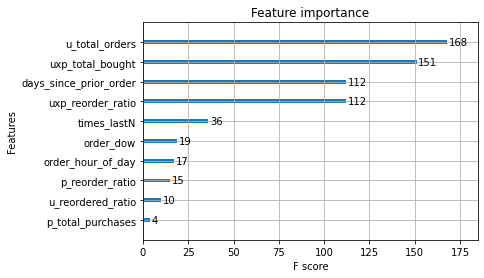

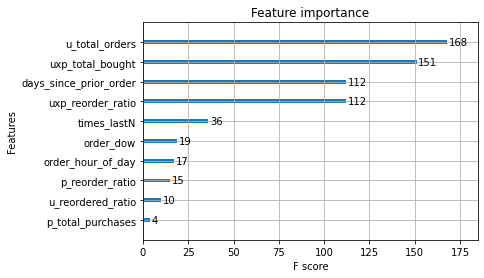

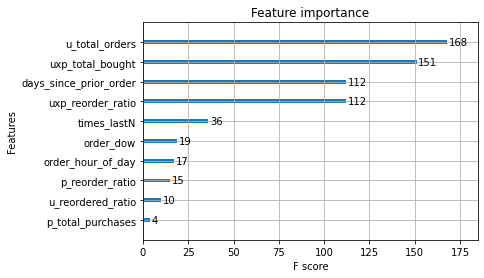

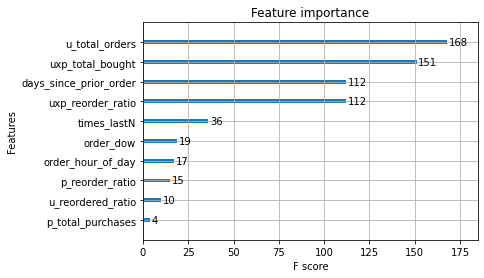

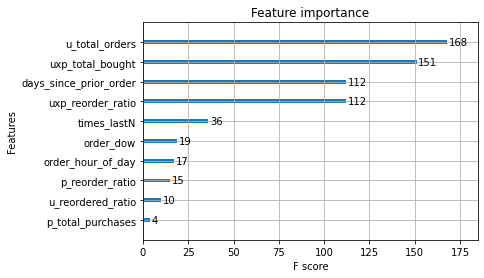

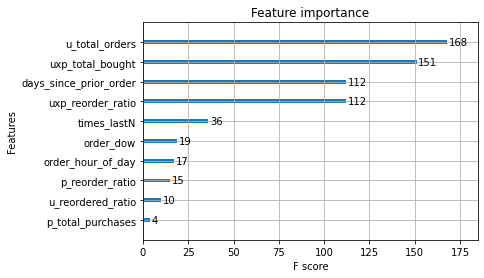

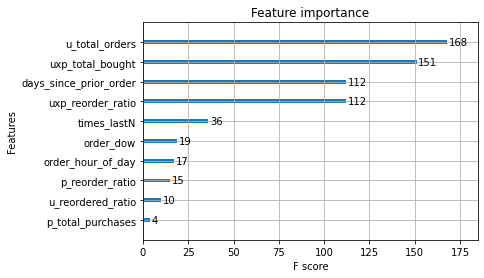

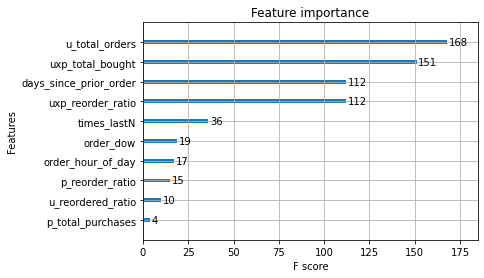

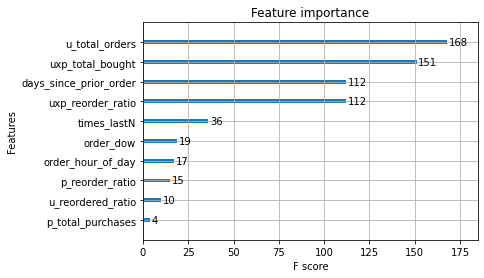

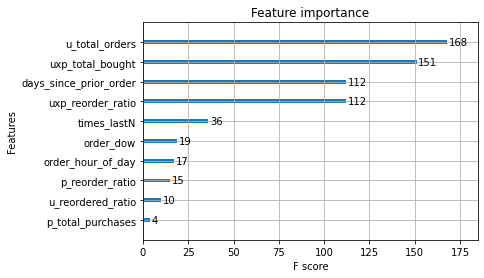

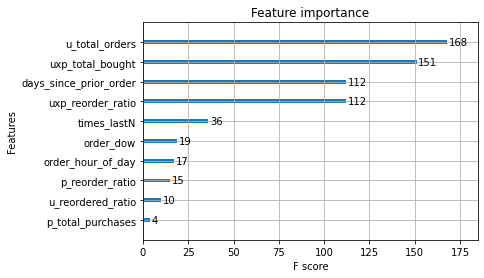

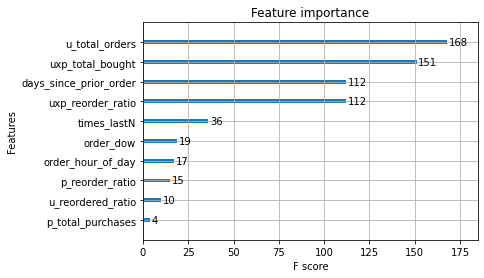

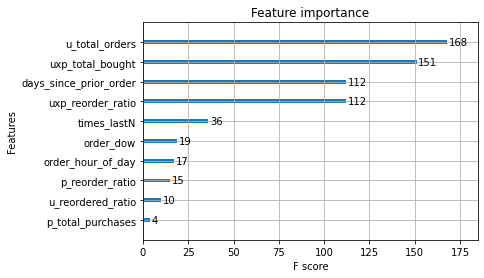

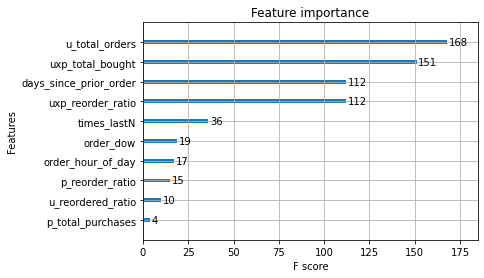

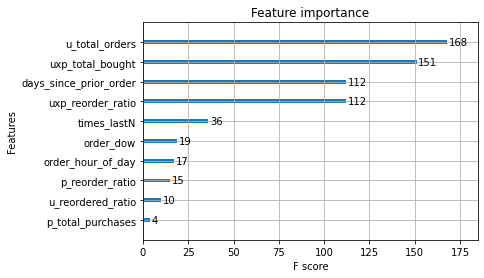

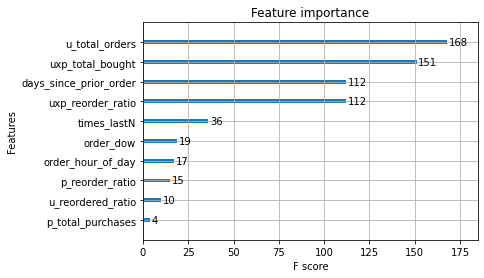

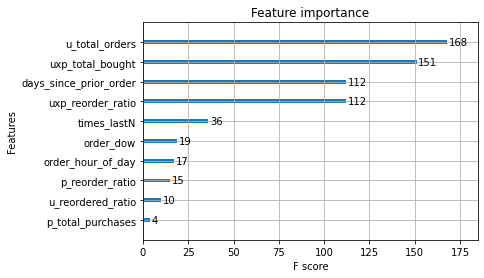

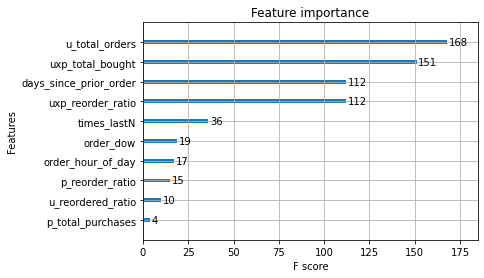

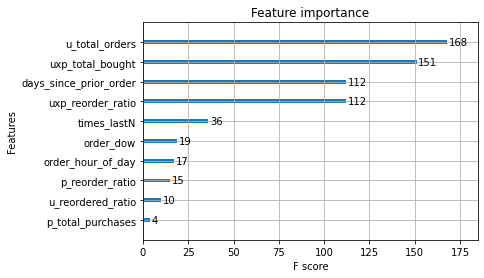

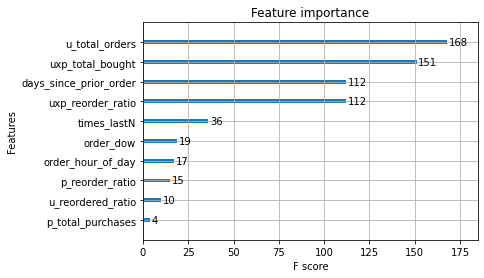

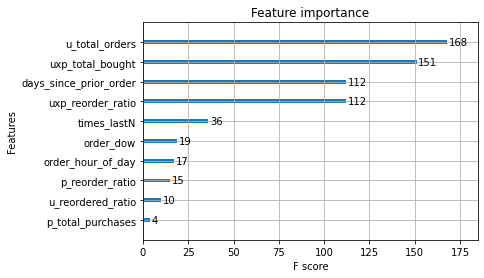

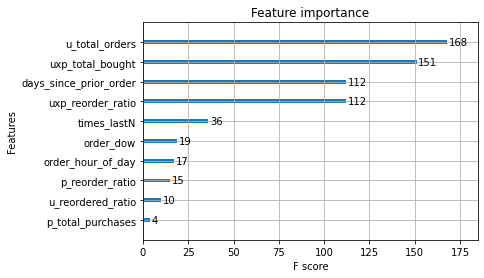

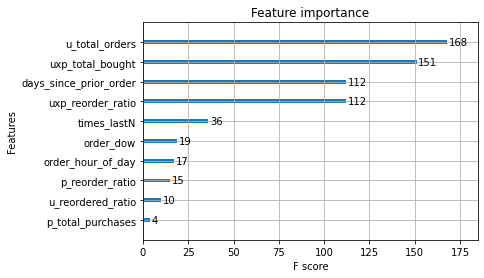

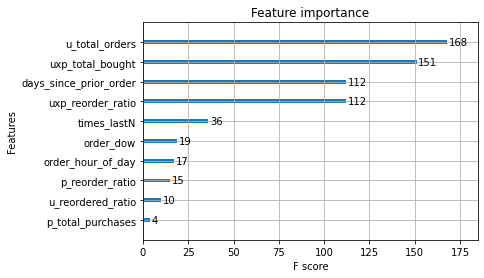

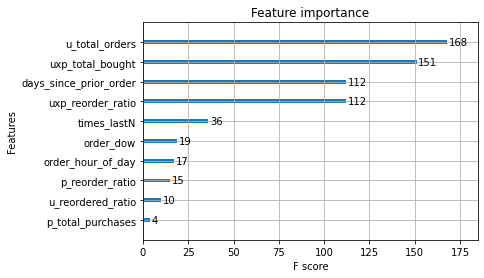

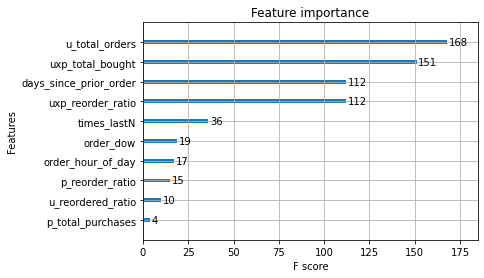

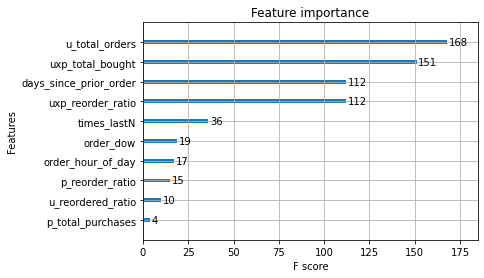

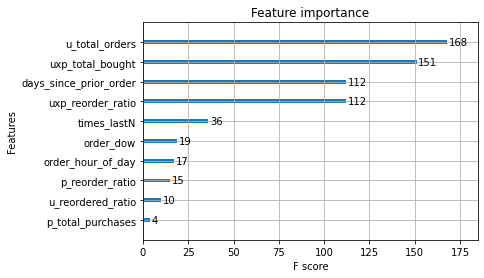

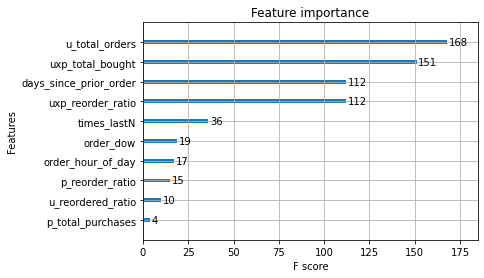

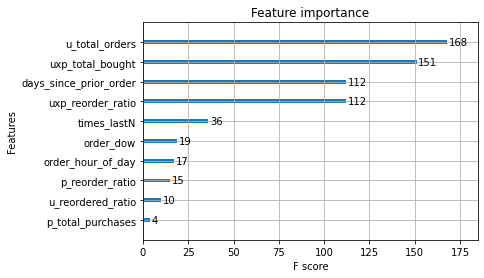

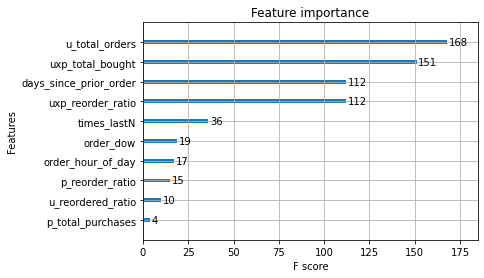

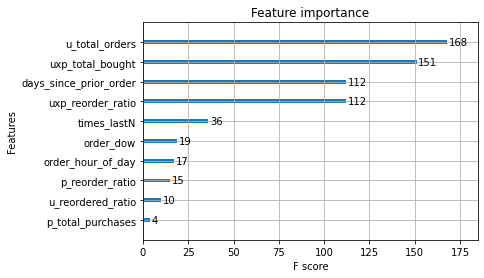

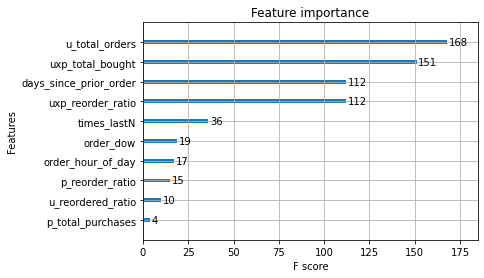

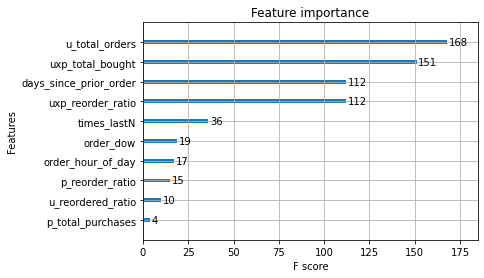

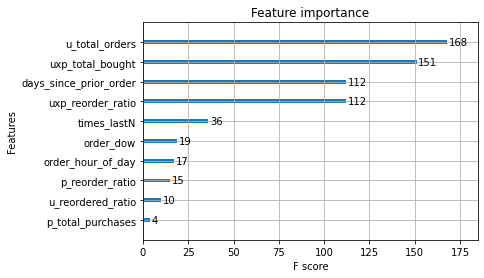

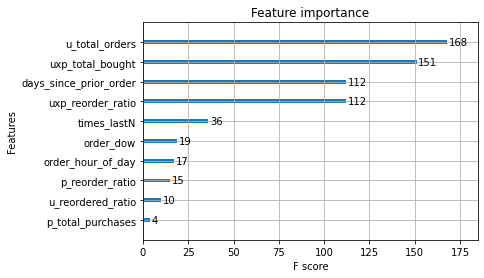

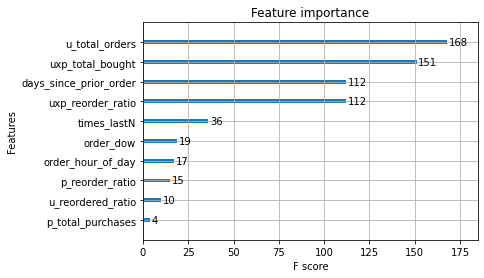

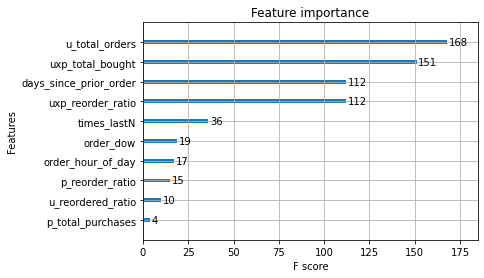

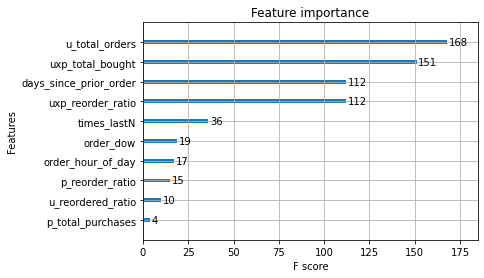

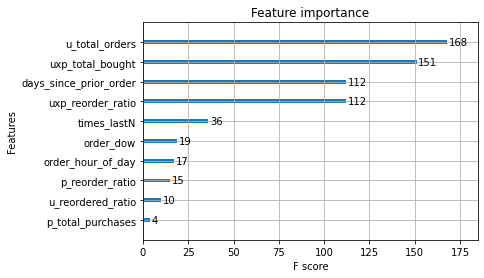

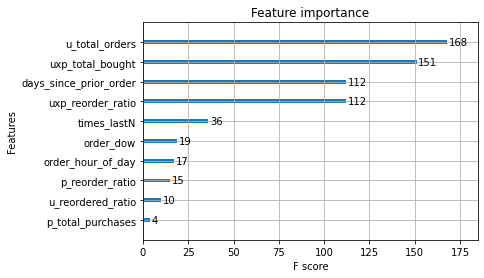

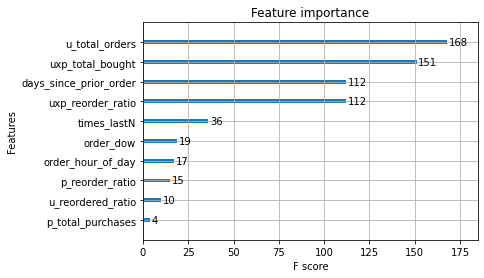

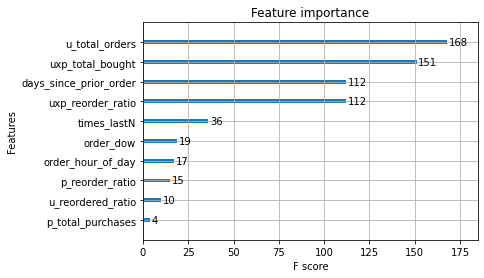

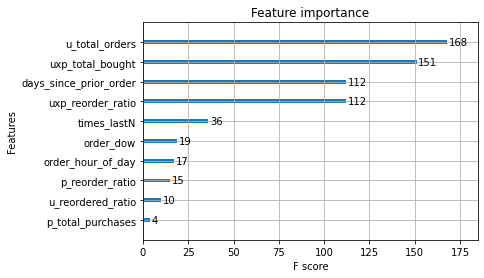

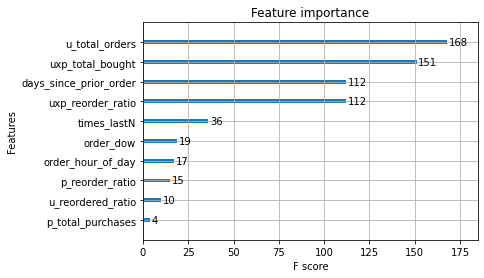

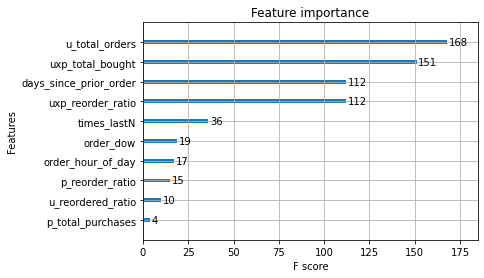

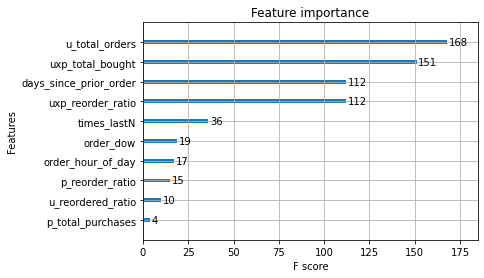

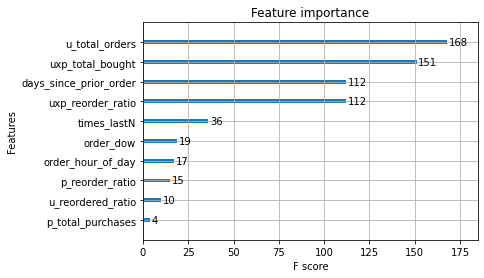

In [ ]:
best_params = params[0]
best_quality = 0

for param in tqdm(params, position=0):
  X_train, y_train = new_data_train[feat_cols[:-1]], new_data_train[feat_cols[-1]]

  xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=param, num_boost_round=10, n_jobs=-1, silent=False)

  model_xgb = xgbc.fit(X_train, y_train)

  xgb.plot_importance(model_xgb)

  precision_xgb = {}
  recall_xgb = {}
  for i in range(1, 11):
    precision_xgb[i] = 0
    recall_xgb[i] = 0

  total = 0

  for user_id, group_u in new_val_set.groupby('user_id'):

    for order_id, group_o in group_u.groupby('order_id'):
      #Купленные товары
      bought = np.array(list(set(group_o['product_id'])))

      #Ищем товары, которые порекомендует бустинг
      order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
      prods = prods_df[prods_df['user_id']==user_id].drop_duplicates(subset=['product_id'])

      prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
      prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
      prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

      prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

      for i in range(1, 11):
        recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))
        precision_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/recommended_xgb.shape[0]
        recall_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/bought.shape[0]

      total += 1

  for i in range(1, 11):
    precision_xgb[i] = precision_xgb[i]/total
    recall_xgb[i] = recall_xgb[i]/total

  quality_precision = []
  quality_recall = []

  for i in range(1, 11):
    quality_precision.append(precision_xgb[i])
    quality_recall.append(recall_xgb[i])
  new_quality = (np.mean(quality_precision) + np.mean(quality_recall))/2.

  if new_quality > best_quality:
    best_quality = new_quality
    best_params = param

print(best_params)

###Обучаем и проверяем качество на валидации

С признаками w2v

100%|██████████| 6605/6605 [05:04<00:00, 21.67it/s]




{1: 0.48523845571536717, 2: 0.44000757002271007, 3: 0.4051476154428444, 4: 0.376810497098158, 5: 0.3543918748422754, 6: 0.33570653545293744, 7: 0.3206475974189951, 8: 0.3072756930175552, 9: 0.29627497807097836, 10: 0.28602600843515896}
{1: 0.08801493583697664, 2: 0.1466071969771405, 3: 0.19508364681607313, 4: 0.23332155894226245, 5: 0.2678504638633832, 6: 0.2982015252276272, 7: 0.3255127214926126, 8: 0.3511032351277985, 9: 0.37480850014842754, 10: 0.39584588541270743}


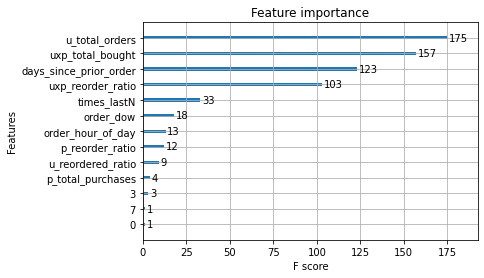

In [ ]:
feat_cols = ['uxp_total_bought', 'uxp_reorder_ratio', 'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases',
             'p_reorder_ratio', 'order_dow', 'order_hour_of_day', 'days_since_prior_order',
             '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'label']

X_train, y_train = new_data_train[feat_cols[:-1]], new_data_train[feat_cols[-1]]

parameters = best_params

xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10, n_jobs=-1, silent=False)

model_xgb = xgbc.fit(X_train, y_train)

xgb.plot_importance(model_xgb)


precision_xgb = {}
recall_xgb = {}
for i in range(1, 11):
  precision_xgb[i] = 0
  recall_xgb[i] = 0

total = 0

for user_id, group_u in tqdm(new_val_set.groupby('user_id'), position=0):

  for order_id, group_o in group_u.groupby('order_id'):
    #Купленные товары
    bought = np.array(list(set(group_o['product_id'])))

    #Ищем товары, которые порекомендует бустинг
    order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
    prods = prods_df[prods_df['user_id']==user_id].drop_duplicates(subset=['product_id'])

    prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
    prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
    prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

    prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

    for i in range(1, 11):
      recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))
      precision_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/recommended_xgb.shape[0]
      recall_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/bought.shape[0]

    total += 1

for i in range(1, 11):
  precision_xgb[i] = precision_xgb[i]/total
  recall_xgb[i] = recall_xgb[i]/total

print('\n')
print(precision_xgb)
print(recall_xgb)

Без признаков w2v

100%|██████████| 6605/6605 [05:17<00:00, 20.79it/s]




{1: 0.4573807721423164, 2: 0.40995457986373957, 3: 0.37170073176886054, 4: 0.3430418874589961, 5: 0.31929094120614737, 6: 0.3000580368407741, 7: 0.2849360152842478, 8: 0.27120183122454145, 9: 0.2600045059659072, 10: 0.24982282542084663}
{1: 0.08397486206264411, 2: 0.13725830578257878, 3: 0.17592330991120936, 4: 0.20600201336730378, 5: 0.2291895409241214, 6: 0.24866415872891562, 7: 0.2656058075154829, 8: 0.27989976210744105, 9: 0.2934420846822027, 10: 0.3051873753307771}


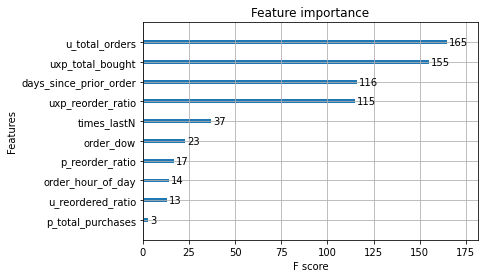

In [ ]:
feat_cols = ['uxp_total_bought', 'uxp_reorder_ratio', 'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases',
             'p_reorder_ratio', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'label']

X_train, y_train = new_data_train[feat_cols[:-1]], new_data_train[feat_cols[-1]]

parameters = best_params

xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10, n_jobs=-1, silent=False)

model_xgb = xgbc.fit(X_train, y_train)

xgb.plot_importance(model_xgb)

precision_xgb = {}
recall_xgb = {}
for i in range(1, 11):
  precision_xgb[i] = 0
  recall_xgb[i] = 0

total = 0

for user_id, group_u in tqdm(new_val_set.groupby('user_id'), position=0):

  for order_id, group_o in group_u.groupby('order_id'):
    #Купленные товары
    bought = np.array(list(set(group_o['product_id'])))

    #Ищем товары, которые порекомендует бустинг
    order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
    prods = prods_df[prods_df['user_id']==user_id].drop_duplicates(subset=['product_id'])

    prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
    prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
    prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

    prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

    for i in range(1, 11):
      recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))
      precision_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/recommended_xgb.shape[0]
      recall_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/bought.shape[0]

    total += 1

for i in range(1, 11):
  precision_xgb[i] = precision_xgb[i]/total
  recall_xgb[i] = recall_xgb[i]/total

print('\n')
print(precision_xgb)
print(recall_xgb)

###Проверяем качество на тесте

С признаками w2v

100%|██████████| 6605/6605 [04:07<00:00, 26.66it/s]




{1: 0.46333489023820645, 2: 0.42213918729565625, 3: 0.3930562042659255, 4: 0.3682702786859724, 5: 0.3481908765374358, 6: 0.33090300482640067, 7: 0.3178116589933585, 8: 0.30653188318765134, 9: 0.2958956280628442, 10: 0.28632481483952055}
{1: 0.0812302003315941, 2: 0.1371491068500306, 3: 0.18500946787980352, 4: 0.2255301768792638, 5: 0.2596876941306564, 6: 0.28968485532191374, 7: 0.317850510825213, 8: 0.3440541161650483, 9: 0.36770085309572415, 10: 0.38920785554653897}


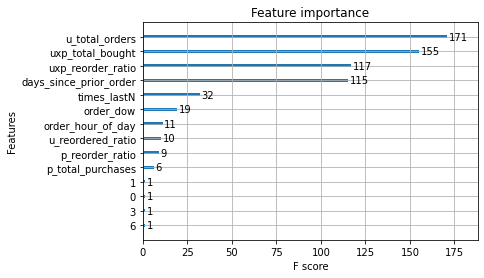

In [ ]:
feat_cols = ['uxp_total_bought', 'uxp_reorder_ratio', 'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases',
             'p_reorder_ratio', 'order_dow', 'order_hour_of_day', 'days_since_prior_order',
             '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', 'label']

X_train, y_train = new_data_train[feat_cols[:-1]], new_data_train[feat_cols[-1]]

parameters = best_params

xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10, n_jobs=-1, silent=False)

model_xgb = xgbc.fit(X_train, y_train)

xgb.plot_importance(model_xgb)

precision_xgb = {}
recall_xgb = {}
for i in range(1, 11):
  precision_xgb[i] = 0
  recall_xgb[i] = 0

total = 0

for user_id, group_u in tqdm(new_test_set.groupby('user_id'), position=0):

  for order_id, group_o in group_u.groupby('order_id'):
    #Купленные товары
    bought = np.array(list(set(group_o['product_id'])))

    #Ищем товары, которые порекомендует бустинг
    order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
    prods = prods_df[prods_df['user_id']==user_id].drop_duplicates(subset=['product_id'])

    prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
    prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
    prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

    prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

    for i in range(1, 11):
      recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))
      precision_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/recommended_xgb.shape[0]
      recall_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/bought.shape[0]

    total += 1

for i in range(1, 11):
  precision_xgb[i] = precision_xgb[i]/total
  recall_xgb[i] = recall_xgb[i]/total

print('\n')
print(precision_xgb)
print(recall_xgb)

metric_with_w2v_feats = {}

metric_with_w2v_feats[it] = [precision_xgb, recall_xgb]

with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/word_to_vec/{0}/metric_with_w2v_feats.pkl'.format(it), 'wb', ) as f:
  pkl.dump(metric_with_w2v_feats, f)

Без признаков w2v

  6%|▋         | 426/6605 [00:15<03:46, 27.28it/s]

KeyboardInterrupt: ignored

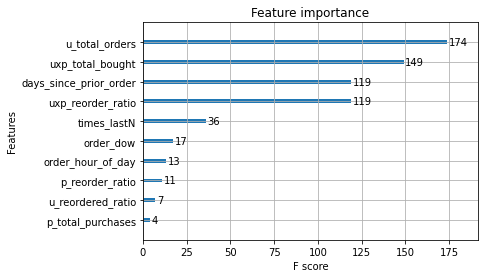

In [ ]:
feat_cols = ['uxp_total_bought', 'uxp_reorder_ratio', 'times_lastN', 'u_total_orders', 'u_reordered_ratio', 'p_total_purchases',
             'p_reorder_ratio', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'label']

X_train, y_train = new_data_train[feat_cols[:-1]], new_data_train[feat_cols[-1]]

parameters = best_params

xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10, n_jobs=-1, silent=False)

model_xgb = xgbc.fit(X_train, y_train)

xgb.plot_importance(model_xgb)

precision_xgb = {}
recall_xgb = {}
for i in range(1, 11):
  precision_xgb[i] = 0
  recall_xgb[i] = 0

total = 0

for user_id, group_u in tqdm(new_test_set.groupby('user_id'), position=0):

  for order_id, group_o in group_u.groupby('order_id'):
    #Купленные товары
    bought = np.array(list(set(group_o['product_id'])))

    #Ищем товары, которые порекомендует бустинг
    order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
    prods = prods_df[prods_df['user_id']==user_id].drop_duplicates(subset=['product_id'])

    prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
    prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
    prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

    prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

    for i in range(1, 11):
      recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))
      precision_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/recommended_xgb.shape[0]
      recall_xgb[i] += np.intersect1d(bought, recommended_xgb).shape[0]/bought.shape[0]

    total += 1

for i in range(1, 11):
  precision_xgb[i] = precision_xgb[i]/total
  recall_xgb[i] = recall_xgb[i]/total

print('\n')
print(precision_xgb)
print(recall_xgb)

metric_without_w2v_feats = {}

metric_without_w2v_feats[it] = [precision_xgb, recall_xgb]

with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/word_to_vec/{0}/metric_without_w2v_feats.pkl'.format(it), 'wb') as f:
  pkl.dump(metric_without_w2v_feats, f)

In [ ]:
products = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Diplom/instacart-market-basket-analysis/products.csv')

In [ ]:
for user_id, group_u in tqdm(new_test_set.groupby('user_id'), position=0):

  for order_id, group_o in group_u.groupby('order_id'):
    #Купленные товары
    bought = np.array(list(set(group_o['product_id'])))

    #Ищем товары, которые порекомендует бустинг
    order = group_o[['order_id', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
    prods = prods_df[prods_df['user_id']==user_id].drop_duplicates(subset=['product_id'])

    prods['order_dow'] = prods['order_dow'].apply(lambda x: order['order_dow'].values[0])
    prods['order_hour_of_day'] = prods['order_hour_of_day'].apply(lambda x: order['order_hour_of_day'].values[0])
    prods['days_since_prior_order'] = prods['days_since_prior_order'].apply(lambda x: order['days_since_prior_order'].values[0])

    prods['prob'] =  model_xgb.predict_proba(prods[feat_cols[:-1]])[:, 1]

    for i in range(1, 11):
      recommended_xgb = np.array(list(map(lambda x:int(x[0]),sorted(prods[['product_id', 'prob']].values, key=lambda x: x[1], reverse=True)[:i])))


  3%|▎         | 177/6605 [00:06<04:00, 26.69it/s]


KeyboardInterrupt: ignored

In [ ]:
products[products['product_id'].isin(bought)][['product_id', 'product_name']]

,product_id,product_name
2752,2753,Blueberry Drinkable Whole Milk Yogurt
3956,3957,100% Raw Coconut Water
8276,8277,Apple Honeycrisp Organic
9622,9623,Sparkling Natural Spring Water
9861,9862,Cold Pressed Fuji Apple Juice
10748,10749,Organic Red Bell Pepper
13291,13292,"Juice Beverage, Cold Pressed, Kale Apple Ginge..."
14672,14673,Natural Glass and Surface Cleaner
18979,18980,Organic Whole Milk Plain Greek Yogurt
21136,21137,Organic Strawberries


In [ ]:
recommended_xgb

array([ 4591, 35419, 48812, 22290,  2238,  7751, 31066])

In [ ]:
bought

array([43616, 47591, 26604, 10768, 17553, 21267, 37947, 36735])

In [ ]:
products[products['product_id'].isin(recommended_xgb)][['product_id', 'product_name']]

,product_id,product_name
3956,3957,100% Raw Coconut Water
9622,9623,Sparkling Natural Spring Water
9861,9862,Cold Pressed Fuji Apple Juice
13291,13292,"Juice Beverage, Cold Pressed, Kale Apple Ginge..."
32577,32578,Organic Fresh Squeezed Orange Juice
34269,34270,"Cold-pressed, Deliciously Hydrating Watermelon..."


In [ ]:
recommended_xgb

array([22046,  6184, 22610, 36051,  2433, 14419,  4020, 47404, 10441,
       33768])

# Смотрим статистики

In [ ]:
precision_with = {}
recall_with = {}
for i in range(1, 11):
  precision_with[i] = []
  recall_with[i] = []

precision_without = {}
recall_without = {}
for i in range(1, 11):
  precision_without[i] = []
  recall_without[i] = []

for i in range(1, 11):
  with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/word_to_vec/{0}/metric_with_w2v_feats.pkl'.format(i), 'rb') as f:
    metric_with = pkl.load(f)
  prec, rec = metric_with[i]
  for key, val in prec.items():
    precision_with[key].append(val)
  for key, val in rec.items():
    recall_with[key].append(val)

  with open('/content/drive/My Drive/Colab Notebooks/Diplom/models/word_to_vec/{0}/metric_without_w2v_feats.pkl'.format(i), 'rb') as f:
    metric_without = pkl.load(f)
  prec, rec = metric_without[i]
  for key, val in prec.items():
    precision_without[key].append(val)
  for key, val in rec.items():
    recall_without[key].append(val)

In [ ]:
for i in range(1, 11):
  print('Shapiro for precision i={0}: '.format(i))
  print('metric_with: '.format(i), stats.shapiro(np.array(precision_with[i])))
  print('metric_without: '.format(i), stats.shapiro(np.array(precision_without[i])))

print('\n')

for i in range(1, 11):
  print('Shapiro for recall i={0}: '.format(i))
  print('metric_with: '.format(i), stats.shapiro(np.array(recall_with[i])))
  print('metric_without: '.format(i), stats.shapiro(np.array(recall_without[i])))

Shapiro for precision i=1: 
metric_with:  (0.9702013731002808, 0.8927063345909119)
metric_without:  (0.9456885457038879, 0.6178553104400635)
Shapiro for precision i=2: 
metric_with:  (0.9599542021751404, 0.7853500247001648)
metric_without:  (0.9412281513214111, 0.5667588710784912)
Shapiro for precision i=3: 
metric_with:  (0.9376470446586609, 0.5271412134170532)
metric_without:  (0.9020146727561951, 0.23051023483276367)
Shapiro for precision i=4: 
metric_with:  (0.9522433280944824, 0.6950801014900208)
metric_without:  (0.9212633967399597, 0.36761316657066345)
Shapiro for precision i=5: 
metric_with:  (0.8781538009643555, 0.1242670863866806)
metric_without:  (0.9624001979827881, 0.8128570914268494)
Shapiro for precision i=6: 
metric_with:  (0.9214419722557068, 0.3691389560699463)
metric_without:  (0.9103760123252869, 0.2835841178894043)
Shapiro for precision i=7: 
metric_with:  (0.8700544238090515, 0.10011173784732819)
metric_without:  (0.9492239356040955, 0.6593273282051086)
Shapiro fo

In [ ]:
for i in range(1, 11):
  print('Student\'s ttest_rel test precision i={0}: '.format(i), stats.ttest_rel(precision_with[i], precision_without[i]))

print('\n')

for i in range(1, 11):
  print('Student\'s ttest_rel i={0}: '.format(i), stats.ttest_rel(recall_with[i], recall_without[i]))

Student's ttest_rel test precision i=1:  Ttest_relResult(statistic=0.4622927239707434, pvalue=0.654843839611809)
Student's ttest_rel test precision i=2:  Ttest_relResult(statistic=-2.130743759598208, pvalue=0.061946547694543413)
Student's ttest_rel test precision i=3:  Ttest_relResult(statistic=1.350987404957158, pvalue=0.20968170567086342)
Student's ttest_rel test precision i=4:  Ttest_relResult(statistic=-2.283348304744169, pvalue=0.04829728450242627)
Student's ttest_rel test precision i=5:  Ttest_relResult(statistic=-5.237256000053339, pvalue=0.0005367176113685103)
Student's ttest_rel test precision i=6:  Ttest_relResult(statistic=-2.7136021012002938, pvalue=0.023856384540105576)
Student's ttest_rel test precision i=7:  Ttest_relResult(statistic=-4.871064845314798, pvalue=0.0008822157744998234)
Student's ttest_rel test precision i=8:  Ttest_relResult(statistic=-8.267308433451921, pvalue=1.7006878588248483e-05)
Student's ttest_rel test precision i=9:  Ttest_relResult(statistic=-12.86

Text(0.5, 1.0, 'Word2Vec BoxPlot for precision k=1')

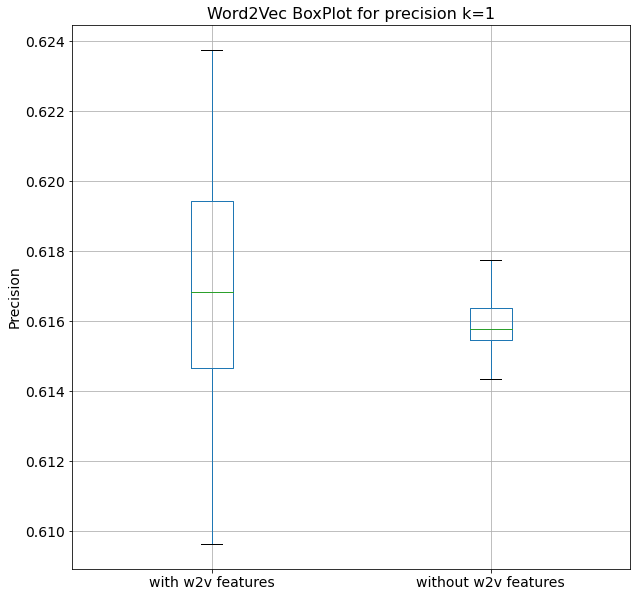

In [ ]:
k = 1
box_plot_df = pd.concat((pd.DataFrame(np.reshape(precision_with[k], (-1,)), columns=['with w2v features']), pd.DataFrame(np.reshape(precision_without[k], (-1,)), columns=['without w2v features'])), axis=1)

box_plot_df.plot.box(grid=True, figsize=(10,10), fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Word2Vec BoxPlot for precision k={0}'.format(k), fontsize=16)

# plt.text(2.6, 0.624, 'Shapiro test:', fontsize=14)
# plt.text(3.58, 0.624, 'statistic                     p-value', fontsize=14)
# plt.text(2.6, 0.623, 'metric with w2v features:      {0}'.format(stats.shapiro(np.array(precision_with[k]))), fontsize=14)
# plt.text(2.6, 0.622, 'metric without w2v features: {0}'.format(stats.shapiro(np.array(precision_without[k]))), fontsize=14)

Text(0.5, 1.0, 'Word2Vec BoxPlot for precision k=3')

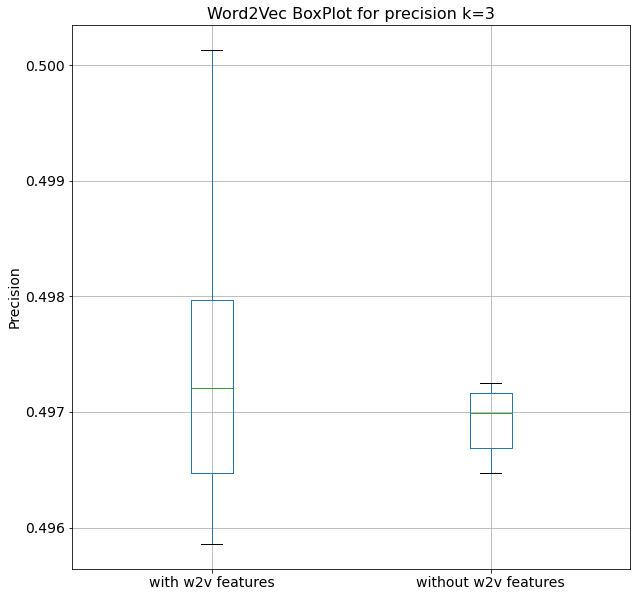

In [ ]:
k = 3
box_plot_df = pd.concat((pd.DataFrame(np.reshape(precision_with[k], (-1,)), columns=['with w2v features']), pd.DataFrame(np.reshape(precision_without[k], (-1,)), columns=['without w2v features'])), axis=1)

box_plot_df.plot.box(grid=True, figsize=(10,10), fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Word2Vec BoxPlot for precision k={0}'.format(k), fontsize=16)

# plt.text(2.6, 0.500, 'Shapiro test:', fontsize=14)
# plt.text(3.58, 0.500, 'statistic                     p-value', fontsize=14)
# plt.text(2.6, 0.4997, 'metric with w2v features:      {0}'.format(stats.shapiro(np.array(precision_with[k]))), fontsize=14)
# plt.text(2.6, 0.4994, 'metric without w2v features: {0}'.format(stats.shapiro(np.array(precision_without[k]))), fontsize=14)

Text(0.5, 1.0, 'Word2Vec BoxPlot for precision k=4')

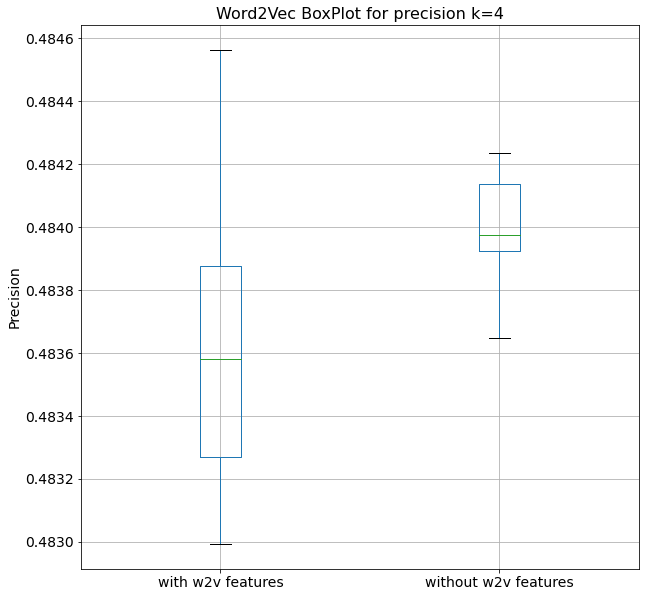

In [ ]:
k = 4
box_plot_df = pd.concat((pd.DataFrame(np.reshape(precision_with[k], (-1,)), columns=['with w2v features']), pd.DataFrame(np.reshape(precision_without[k], (-1,)), columns=['without w2v features'])), axis=1)

box_plot_df.plot.box(grid=True, figsize=(10,10), fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Word2Vec BoxPlot for precision k={0}'.format(k), fontsize=16)

# plt.text(2.6, 0.500, 'Shapiro test:', fontsize=14)
# plt.text(3.58, 0.500, 'statistic                     p-value', fontsize=14)
# plt.text(2.6, 0.4997, 'metric with w2v features:      {0}'.format(stats.shapiro(np.array(precision_with[k]))), fontsize=14)
# plt.text(2.6, 0.4994, 'metric without w2v features: {0}'.format(stats.shapiro(np.array(precision_without[k]))), fontsize=14)

Text(0.5, 1.0, 'Word2Vec BoxPlot for recall k=1')

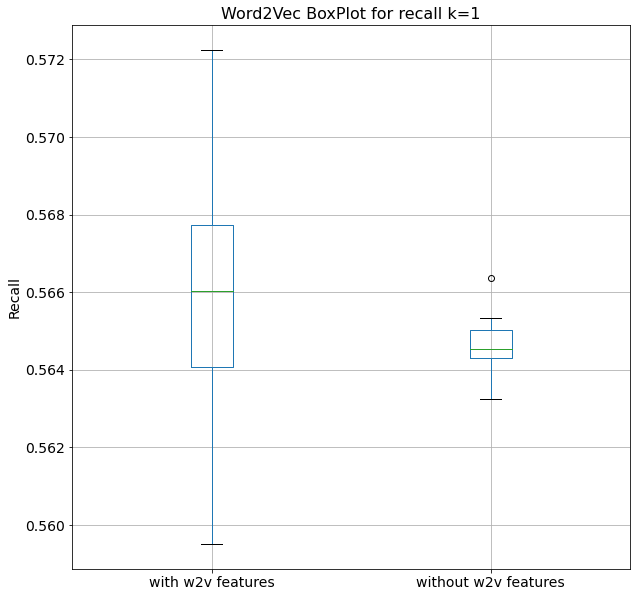

In [ ]:
k = 1
box_plot_df = pd.concat((pd.DataFrame(np.reshape(recall_with[k], (-1,)), columns=['with w2v features']), pd.DataFrame(np.reshape(recall_without[k], (-1,)), columns=['without w2v features'])), axis=1)

box_plot_df.plot.box(grid=True, figsize=(10,10), fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.title('Word2Vec BoxPlot for recall k={0}'.format(k), fontsize=16)

# plt.text(2.6, 0.572, 'Shapiro test:', fontsize=14)
# plt.text(3.58, 0.572, 'statistic                     p-value', fontsize=14)
# plt.text(2.6, 0.571, 'metric with w2v features:      {0}'.format(stats.shapiro(np.array(recall_with[k]))), fontsize=14)
# plt.text(2.6, 0.570, 'metric without w2v features: {0}'.format(stats.shapiro(np.array(recall_without[k]))), fontsize=14)

Text(0.5, 1.0, 'Word2Vec BoxPlot for recall k=3')

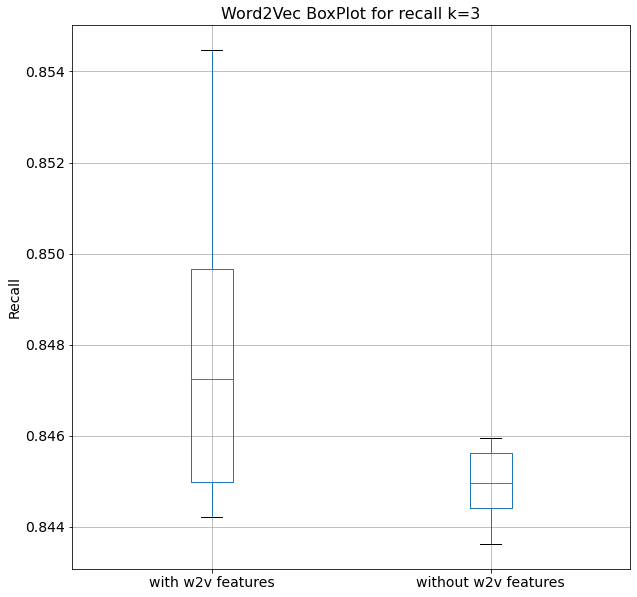

In [ ]:
k = 3
box_plot_df = pd.concat((pd.DataFrame(np.reshape(recall_with[k], (-1,)), columns=['with w2v features']), pd.DataFrame(np.reshape(recall_without[k], (-1,)), columns=['without w2v features'])), axis=1)

box_plot_df.plot.box(grid=True, figsize=(10,10), fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.title('Word2Vec BoxPlot for recall k={0}'.format(k), fontsize=16)

# plt.text(2.6, 0.854, 'Shapiro test:', fontsize=14)
# plt.text(3.58, 0.854, 'statistic                     p-value', fontsize=14)
# plt.text(2.6, 0.8532, 'metric with w2v features:      {0}'.format(stats.shapiro(np.array(recall_with[k]))), fontsize=14)
# plt.text(2.6, 0.8523, 'metric without w2v features: {0}'.format(stats.shapiro(np.array(recall_without[k]))), fontsize=14)

Text(0.5, 1.0, 'Word2Vec BoxPlot for recall k=4')

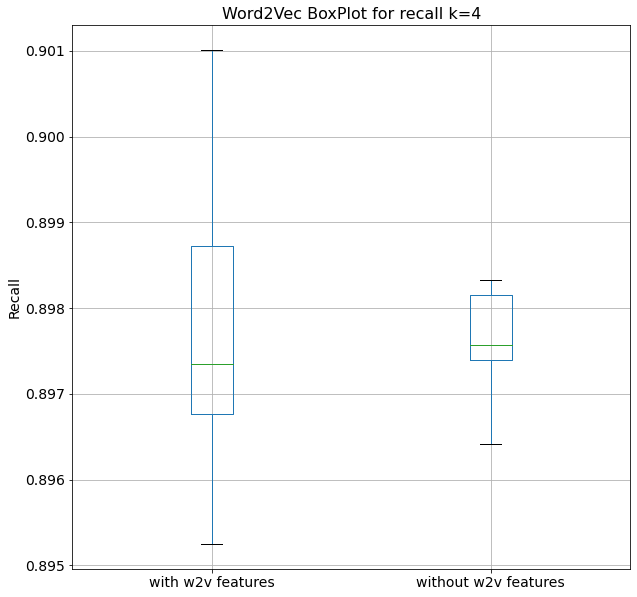

In [ ]:
k = 4
box_plot_df = pd.concat((pd.DataFrame(np.reshape(recall_with[k], (-1,)), columns=['with w2v features']), pd.DataFrame(np.reshape(recall_without[k], (-1,)), columns=['without w2v features'])), axis=1)

box_plot_df.plot.box(grid=True, figsize=(10,10), fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.title('Word2Vec BoxPlot for recall k={0}'.format(k), fontsize=16)

# plt.text(2.6, 0.854, 'Shapiro test:', fontsize=14)
# plt.text(3.58, 0.854, 'statistic                     p-value', fontsize=14)
# plt.text(2.6, 0.8532, 'metric with w2v features:      {0}'.format(stats.shapiro(np.array(recall_with[k]))), fontsize=14)
# plt.text(2.6, 0.8523, 'metric without w2v features: {0}'.format(stats.shapiro(np.array(recall_without[k]))), fontsize=14)

In [ ]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [ ]:
for i in range(1, 11):
  print('Confidence_interval precision i={0}: '.format(i))
  print('metric_with: ', mean_confidence_interval(precision_with[i]))
  print('metric_without: ', mean_confidence_interval(precision_without[i]))

print('\n')

for i in range(1, 11):
  print('Confidence_interval recall i={0}: '.format(i))
  print('metric_with: ', mean_confidence_interval(recall_with[i]))
  print('metric_without: ', mean_confidence_interval(recall_without[i]))